Install necessary environment. Besides, this notebook requires Pytorch to work.

In [2]:
!pip install gym-tetris

  Using cached gym_tetris-3.0.4-py3-none-any.whl (34 kB)


In [1]:
!pip install nes-py

  Using cached nes_py-8.2.1.tar.gz (77 kB)
  Created wheel for nes-py: filename=nes_py-8.2.1-cp39-cp39-win_amd64.whl size=45867 sha256=49a5b894a1b58bf41b31020934c63ed342c26cf04abf19f4dfab41b5918eafe4
  Stored in directory: c:\users\32698\appdata\local\pip\cache\wheels\c6\e1\4b\dbbd5d4a46ad80c0149d5671edb272c728c130e4d5750ca1d2
Successfully built nes-py


In [1]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
shape = {
    'Td': [
        np.array([[1, 1, 1], 
                  [0, 1, 0]]),
        np.array([[0, 1], 
                  [1, 1],
                  [0, 1]]),
        np.array([[0, 1, 0], 
                  [1, 1, 1]]),
        np.array([[1, 0], 
                  [1, 1],
                  [1, 0]])
    ],
    'Jd': [
        np.array([[1, 1, 1],
                  [0, 0, 1]]),
        np.array([[0, 1], 
                  [0, 1],
                  [1, 1]]),
        np.array([[1, 0, 0],
                  [1, 1, 1]]),
        np.array([[1, 1], 
                  [1, 0],
                  [1, 0]])
    ],
    'Zh': [
        np.array([[1, 1, 0],
                  [0, 1, 1]]),
        np.array([[0, 1], 
                  [1, 1],
                  [1, 0]])
    ], 
    'O': [
        np.array([[1, 1],
                  [1, 1]])
    ], 
    'Sh': [
        np.array([[0, 1, 1],
                  [1, 1, 0]]),
        np.array([[1, 0], 
                  [1, 1],
                  [0, 1]])
    ], 
    'Ld': [
        np.array([[1, 1, 1],
                  [1, 0, 0]]),
        np.array([[1, 1], 
                  [0, 1],
                  [0, 1]]),
        np.array([[0, 0, 1],
                  [1, 1, 1]]),
        np.array([[1, 0], 
                  [1, 0],
                  [1, 1]])
    ],
    'Ih': [
        np.array([[1, 1, 1, 1]]),
        np.array([[1],
                  [1],
                  [1],
                  [1]])
    ]
}

In [3]:
# Detect collision
def collision(board, piece, row):
    if row + piece.shape[0] > 20:
        return True
    for i in range(piece.shape[0]):
        for j in range(piece.shape[1]):
            if piece[i, j] == 1 and board[row+i, j] == 1:
                return True
    return False

# Clear full rows in possible states
def clear_full_rows(board):
    full_rows = []
    for i in range(board.shape[0]):
        if np.all(board[i, :] == 1):
            full_rows.append(i)

    if full_rows:
        board = np.delete(board, full_rows, axis=0)
        new_rows = np.zeros((len(full_rows), board.shape[1]), dtype=int)
        board = np.vstack((new_rows, board))

    return board, len(full_rows)

# For current piece to fall, enumurate all possible situations of performing diff actions
# Return the dict:   {(x_coordinate, num_rotation): state_statistics}
def get_possible_states(state, piece):
    # Set of states
    states = {}
    # Current piece
    pshape = shape[piece]
    for s in range(len(pshape)):   # Each rotation
        p = pshape[s]
        ws = p.shape[1]
        hs = p.shape[0]
        valid_x = 10 - ws
        for x in range(valid_x + 1):       # Each position
            _state = state.copy()
            state_slice = _state[:, x : x + ws]
            for h in range(0, 20):
                if collision(state_slice, p, h):
                    if not h:
                        break
                    for i in range(hs):
                        for j in range(ws):
                            if p[i, j] == 1:
                                state_slice[h-1+i, j] = 1
                    _state, clear_lines = clear_full_rows(_state)
                    states[(x, s)] = state_convert(_state, clear_lines)
                    break               
    return states

In [4]:
# Aciton：[x, y]
# x is the x coordinate to descend, 0 - 9
# y is the times of rotation, 0-3
# Input action [x, y]，convert it to the operations that environment reconizes to do env.step()
def action_execute(action, env):
    for i in range(action[1]):
        env.step(1)
        env.step(0)   
    for i in range(5):
        env.step(4)
        env.step(0)
    for i in range(action[0]):
        env.step(3)
        env.step(0)
    state, reward, done, info = env.step(0)
    return info

In [5]:
# Convert raw RGB state to 2D binary matrix
def RGB_to_binary(state):
    rgb_array = np.array(state)
    arr = np.sum(rgb_array[48:208, 95:175], axis=2)
    arr = (arr[0::8, 1::8]>0).astype(int)
    return arr

def get_cavity(state):
    cavity = 0
    for j in range(10):
        consecutive_zeros = 0
        for i in range(19, -1, -1):
            if state[i, j] == 0:
                consecutive_zeros += 1
            elif state[i, j] == 1 and consecutive_zeros > 0:
                cavity += consecutive_zeros
                consecutive_zeros = 0
    return cavity

def get_bumpiness_height(state):
    height = np.zeros(10)
    bumpiness = 0
    for i in range(10):
        for j in range(20):
            if state[j,i] == 1:
                height[i] = 20-j
                break
        if i > 0:
            bumpiness += abs(height[i] - height[i-1])
    return np.sum(height), bumpiness

# Convert binary matrix state to statistics state
def state_convert(state, cleared_lines):
    cavity = get_cavity(state)
    height, bumpiness = get_bumpiness_height(state)
    return cavity, height, cleared_lines, bumpiness

Two options for network architecture.

In [6]:
# FCNN Network defination
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()

        self.conv1 = nn.Sequential(nn.Linear(input_size, 64), nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Linear(64, output_size))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x
    

In [25]:
# CNN Network defination
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 2, 1)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 2)
        x = self.fc1(x)
        return x

In [7]:
# Experience replay defination
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, transition):
        if len(self.buffer) >= self.capacity:
            for i in range(self.capacity):
                if self.buffer[i][3][2] == 0:
                    self.buffer.pop(i)
                    break
                if i == self.capacity-1:
                    self.buffer.pop(0)
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [8]:
# DQN algorithm
class DQNAgent:
    def __init__(self, input_size, output_size, capacity, gamma=0.99, epsilon=1.0):
        self.q_network = DQN(input_size, output_size)    
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.005)
        self.replay_buffer = ReplayBuffer(capacity) 
        self.gamma = gamma       # γ
        self.epsilon = epsilon   # ε

    def select_action(self, states):      # ε- greedy
        actions = list(states.keys())
        if random.random() < self.epsilon:     # exploration
            return random.choice(actions)
        else:
            with torch.no_grad():              # exploitation
                q_values = self.q_network(torch.FloatTensor(list(states.values())))
                return actions[torch.argmax(q_values).item()]

    def update_q_network(self, batch_size):
        if len(self.replay_buffer.buffer) < batch_size:
            return
        transitions = self.replay_buffer.sample(batch_size)   # Sample from buffer
        batch = list(zip(*transitions))
        state_batch = torch.Tensor(batch[0])    # state
        done_batch = torch.Tensor(batch[1])
        reward_batch = torch.FloatTensor(batch[2])   # reward
        next_state_batch = torch.Tensor(batch[3])   # next state

        # Q value
        q_values = self.q_network(state_batch)
        
        # Next Q value
        next_q_values = self.q_network(next_state_batch)
        
        self.q_network.eval()
        with torch.no_grad():
            next_prediction_batch = self.q_network(next_state_batch)
        self.q_network.train()
        
        # Bellman's equation
        expected_q_values = reward_batch + (1-done_batch)*self.gamma * next_q_values
        
        # Update parameters
        self.optimizer.zero_grad()
        loss = nn.MSELoss()(q_values, expected_q_values)
        loss.backward()
        self.optimizer.step()

In [9]:
# Training
Score = []
def train_dqn(env, agent, num_epoch=2000, batch_size=32, test_frequency = 50):
    done = True
    info = None
    state_board = None
    state_statistics = None
    piece = None
    next_state = None
    cur_cleared_lines = 0 

    epoch = 0
    score = 0
    episode = 0
    
    max_score = 0
    
#     reward_score = 0
    
    while 1:
        episode += 1
        if done:
            env.reset()
            _s, _r, done, info = env.step(0)
        
            piece = info['current_piece']     
            state_board = np.zeros((20, 10))  
            state_statistics = np.zeros(4)    
            cur_cleared_lines = 0
            
            if score > max_score:
                torch.save(agent.q_network.state_dict(), 'model_para.pth')
                max_score = score
            
            print(f"Game: {epoch}, score: {score}")
            Score.append(score)
            epoch += 1
            
            # ε decay
            if agent.epsilon >= 0:
                agent.epsilon -= (4.0 / (3.0 * num_epoch) )
            elif agent.epsilon < 0:
                agent.epsilon = 0
            
#             reward_score = 0
            
#             if epoch % test_frequency == 0:
#                 test_dqn(env, agent)
            
            if epoch == num_epoch+1:
                break
            
        # Sample and take action
        next_states = get_possible_states(state_board, piece)
        if next_states != {}:
            action = agent.select_action(next_states)
            info = action_execute(action, env)
        
        # Skip the time before next tetrominoes appears
        cur_sta = sum(info['statistics'].values())
        while not done and sum(info['statistics'].values()) == cur_sta:
            next_state, r, done, info = env.step(5)
            score = info['score']
            env.render()

        next_state_board = RGB_to_binary(next_state)
        cleared_lines = info['number_of_lines'] - cur_cleared_lines
        cur_cleared_lines = info['number_of_lines']
        next_state_statistics = state_convert(next_state_board, cleared_lines)
        
#         next_reward_score = -0.51*next_state_statistics[1]+0.76*next_state_statistics[2]-0.36*next_state_statistics[0]-0.18*next_state_statistics[3]
#         reward = next_reward_score - reward_score
#         reward_score = next_reward_score
        reward = (cleared_lines ** 2) * 10 + 1 - 2 * done
        
        # Push current record into replay buffer
        agent.replay_buffer.push((state_statistics, done, reward, next_state_statistics))

        state_statistics = next_state_statistics
        state_board = next_state_board
        cur_cleared_lines = info['number_of_lines']
        
        # Update Q network
        if len(agent.replay_buffer.buffer) >= batch_size:
            agent.update_q_network(batch_size)

        print(f"Steps: {episode}, Action: {action}, Score: {reward}, Cleared lines: {cleared_lines}")

In [10]:
# Test
Test_Score = []
Test_Gamelength = []

def test_dqn(env, agent, num_epoch=10):
    
    done = True
    info = None
    state_board = None
    piece = None
    next_state = None
    cur_cleared_lines = 0 

    epoch = 0
    score = 0
    episode = 0
    
    scores = []
    gameslen = []
    glen = 0
    
    while 1:
        episode += 1
        glen += 1
        if done:
            env.reset()
            _s, _r, done, info = env.step(0)
        
            piece = info['current_piece']     
            state_board = np.zeros((20, 10))  
            cur_cleared_lines = 0
            
            print(f"TestGame: {epoch}, score: {score}, length: {glen}")
            scores.append(score)
            gameslen.append(glen)
            epoch += 1
            glen = 0
            if epoch == num_epoch+1:
                break
            
        next_states = get_possible_states(state_board, piece)
        if next_states != {}:
            actions = list(next_states.keys())
            with torch.no_grad():              # exploitation
                q_values = agent.q_network(torch.FloatTensor(list(next_states.values())))
            action = actions[torch.argmax(q_values).item()]
            info = action_execute(action, env)
        
        
        cur_sta = sum(info['statistics'].values())
        while not done and sum(info['statistics'].values()) == cur_sta:
            next_state, r, done, info = env.step(5)
            score = info['score']
            env.render()

        next_state_board = RGB_to_binary(next_state)
        cleared_lines = info['number_of_lines'] - cur_cleared_lines
        cur_cleared_lines = info['number_of_lines']
  
        reward = (cleared_lines ** 2) * 10 + 1 - 2 * done

        state_board = next_state_board
        cur_cleared_lines = info['number_of_lines']

        print(f"TestSteps: {episode}, Action: {action}, Score: {reward}, Cleared lines: {cleared_lines}")
    
   
    Test_Score.append(scores)
    Test_Gamelength.append(gameslen)

See training process, run the cell below.

In [27]:
input_size = 4  # State dimension
output_size = 1  # Q value
capacity = 20000  # Buffer capacity

env = JoypadSpace(gym_tetris.make('TetrisA-v1'), SIMPLE_MOVEMENT)

# initialize DQNAgent
agent = DQNAgent(input_size, output_size, capacity)

# train DQN
train_dqn(env, agent, num_epoch=1000, batch_size=512)
env.close()

Game: 0, score: 0
Steps: 1, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 2, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 4, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 5, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 7, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 9, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 11, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 12, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 13, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 14, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 15, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 16, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 17, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 18, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19, Action: 

Steps: 151, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 152, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 153, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 154, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 155, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 156, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 157, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 158, Action: (4, 0), Score: -1, Cleared lines: 0
Game: 7, score: 151
Steps: 159, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 160, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 161, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 162, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 163, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 164, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 165, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 166, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 167, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 168, Action: (6, 2), Score: 1, Cleare

Steps: 299, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 300, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 301, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 302, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 303, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 304, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 305, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 306, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 307, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 308, Action: (2, 2), Score: -1, Cleared lines: 0
Game: 14, score: 138
Steps: 309, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 310, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 311, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 312, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 313, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 314, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 315, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 316, Action: (2, 1), Score: 1, Clear

Steps: 447, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 448, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 449, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 450, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 451, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 452, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 453, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 454, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 455, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 456, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 457, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 458, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 459, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 460, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 461, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 462, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 463, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 464, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 465

Steps: 594, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 595, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 596, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 27, score: 161
Steps: 597, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 598, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 599, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 600, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 601, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 602, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 603, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 604, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 605, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 606, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 607, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 608, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 609, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 610, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 611, Action: (2, 0), Score: 1, Clear

Steps: 740, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 741, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 742, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 743, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 744, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 745, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 746, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 747, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 748, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 749, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 750, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 751, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 752, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 753, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 754, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 755, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 756, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 757, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 758

Steps: 887, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 888, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 889, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 890, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 891, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 892, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 893, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 894, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 895, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 896, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 897, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 898, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 899, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 900, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 901, Action: (1, 1), Score: -1, Cleared lines: 0
Game: 41, score: 133
Steps: 902, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 903, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 904, Action: (0, 1), Score: 1, Clear

Steps: 1033, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 1034, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1035, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 47, score: 184
Steps: 1036, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1037, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1038, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1039, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1040, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1041, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1042, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 1043, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1044, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1045, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1046, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1047, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1048, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1049, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1050, Action: (8, 0

Steps: 1177, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1178, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1179, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1180, Action: (3, 0), Score: -1, Cleared lines: 0
Game: 53, score: 156
Steps: 1181, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 1182, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 1183, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1184, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1185, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 1186, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1187, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 1188, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 1189, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 1190, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1191, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1192, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1193, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 1194, Action: (7, 1

Steps: 1321, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 1322, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 1323, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1324, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1325, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 1326, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1327, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 1328, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 1329, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 1330, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 1331, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 1332, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1333, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1334, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 1335, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1336, Action: (8, 1), Score: -1, Cleared lines: 0
Game: 60, score: 168
Steps: 1337, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1338, Action: (0, 2

Steps: 1465, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1466, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1467, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 1468, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1469, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 1470, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 1471, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1472, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 1473, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 1474, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 1475, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1476, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1477, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 1478, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1479, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1480, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1481, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 1482, Action: (5, 0), Score: 1, Cleared l

Steps: 1609, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1610, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1611, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1612, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1613, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1614, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 1615, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 1616, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1617, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1618, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1619, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 1620, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1621, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1622, Action: (1, 0), Score: -1, Cleared lines: 0
Game: 72, score: 100
Steps: 1623, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1624, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1625, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1626, Action: (0, 0

Steps: 1753, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1754, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1755, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1756, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1757, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1758, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1759, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1760, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1761, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1762, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1763, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1764, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1765, Action: (2, 0), Score: -1, Cleared lines: 0
Game: 78, score: 183
Steps: 1766, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 1767, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1768, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 1769, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 1770, Action: (1, 1

Steps: 1897, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1898, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 1899, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1900, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1901, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1902, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 1903, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1904, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 1905, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1906, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 1907, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1908, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 1909, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 84, score: 145
Steps: 1910, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 1911, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1912, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1913, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1914, Action: (0, 0

Steps: 2041, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2042, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 2043, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 2044, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 2045, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2046, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 2047, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2048, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2049, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 2050, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2051, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 2052, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 2053, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2054, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2055, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2056, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2057, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2058, Action: (0, 0), Score: 1, Cleared l

Steps: 2185, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 2186, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 2187, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 2188, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 2189, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 2190, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 2191, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 2192, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 2193, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2194, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2195, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2196, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 2197, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2198, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 2199, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 2200, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2201, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 2202, Action: (1, 1), Score: 1, Cleared l

Steps: 2330, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 2331, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 2332, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 2333, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 2334, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 2335, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 2336, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 2337, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 2338, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 2339, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2340, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 2341, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 2342, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 2343, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2344, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 2345, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2346, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 2347, Action: (0, 0), Score: 1, Cleared l

Steps: 2474, Action: (6, 0), Score: -1, Cleared lines: 0
Game: 109, score: 163
Steps: 2475, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 2476, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 2477, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 2478, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2479, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 2480, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 2481, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 2482, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 2483, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 2484, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 2485, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 2486, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 2487, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2488, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2489, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2490, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 2491, Action: (2, 

Steps: 2618, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2619, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2620, Action: (5, 0), Score: -1, Cleared lines: 0
Game: 115, score: 145
Steps: 2621, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 2622, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2623, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2624, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 2625, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2626, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2627, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2628, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2629, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2630, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2631, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2632, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 2633, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2634, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2635, Action: (3, 

Steps: 2762, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 2763, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 2764, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 2765, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2766, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 2767, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2768, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 2769, Action: (0, 2), Score: -1, Cleared lines: 0
Game: 121, score: 181
Steps: 2770, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 2771, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2772, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 2773, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 2774, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 2775, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2776, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 2777, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 2778, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 2779, Action: (5, 

Steps: 2907, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2908, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 2909, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 2910, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 2911, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 2912, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2913, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2914, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 2915, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 127, score: 267
Steps: 2916, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2917, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2918, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 2919, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2920, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 2921, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2922, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 2923, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 2924, Action: (6, 

Steps: 3051, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3052, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3053, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3054, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3055, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3056, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3057, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3058, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3059, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3060, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3061, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3062, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3063, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3064, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 3065, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3066, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3067, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3068, Action: (7, 0), Score: 1, Cleared l

Steps: 3195, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 3196, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 3197, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3198, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3199, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3200, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 3201, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3202, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3203, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3204, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 3205, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 3206, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 3207, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 139, score: 145
Steps: 3208, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3209, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3210, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3211, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 3212, Action: (1, 

Steps: 3339, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3340, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3341, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3342, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 3343, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 3344, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 3345, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3346, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3347, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3348, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3349, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3350, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3351, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3352, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3353, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3354, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3355, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3356, Action: (3, 0), Score: -1, Cleared 

Steps: 3484, Action: (0, 3), Score: -1, Cleared lines: 0
Game: 150, score: 200
Steps: 3485, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 3486, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 3487, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 3488, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 3489, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3490, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3491, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3492, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3493, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 3494, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3495, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 3496, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3497, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3498, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 3499, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 3500, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 3501, Action: (4, 

Steps: 3628, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 3629, Action: (7, 2), Score: 11, Cleared lines: 1
Steps: 3630, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 3631, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3632, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 3633, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 3634, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 3635, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 3636, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3637, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 3638, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 3639, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 3640, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 3641, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 3642, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 3643, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 3644, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 3645, Action: (5, 1), Score: 1, Cleared 

Steps: 3772, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 3773, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 3774, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 3775, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 3776, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3777, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3778, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 3779, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3780, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3781, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3782, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3783, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 3784, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 3785, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3786, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3787, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 3788, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3789, Action: (5, 0), Score: 1, Cleared l

Steps: 3917, Action: (3, 0), Score: -1, Cleared lines: 0
Game: 168, score: 176
Steps: 3918, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 3919, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 3920, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3921, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 3922, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 3923, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 3924, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 3925, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 3926, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 3927, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 3928, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 3929, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 3930, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 3931, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 3932, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 3933, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 3934, Action: (2, 

Steps: 4061, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 4062, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 4063, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 4064, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 4065, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 4066, Action: (1, 3), Score: -1, Cleared lines: 0
Game: 174, score: 134
Steps: 4067, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 4068, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 4069, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 4070, Action: (0, 1), Score: 11, Cleared lines: 1
Steps: 4071, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 4072, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 4073, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4074, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4075, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 4076, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4077, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 4078, Action: (7,

Steps: 4205, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 4206, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 4207, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 4208, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 4209, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 4210, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4211, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 4212, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 4213, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 4214, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4215, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 4216, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 4217, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 4218, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 4219, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 4220, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 4221, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 4222, Action: (2, 3), Score: 1, Cleared l

Steps: 4349, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4350, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 4351, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 4352, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 4353, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 4354, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 4355, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 4356, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4357, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4358, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 4359, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4360, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 4361, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 4362, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4363, Action: (2, 3), Score: -1, Cleared lines: 0
Game: 186, score: 143
Steps: 4364, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4365, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 4366, Action: (1, 

Steps: 4493, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 4494, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 4495, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 4496, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 4497, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 4498, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4499, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 4500, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4501, Action: (7, 0), Score: -1, Cleared lines: 0
Game: 192, score: 191
Steps: 4502, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 4503, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4504, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 4505, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4506, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 4507, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 4508, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 4509, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 4510, Action: (5, 

Steps: 4637, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 4638, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 4639, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4640, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 4641, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 4642, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 4643, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 4644, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 4645, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 4646, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 198, score: 130
Steps: 4647, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4648, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 4649, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4650, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4651, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 4652, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4653, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4654, Action: (3, 

Steps: 4782, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 4783, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4784, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 4785, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 4786, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 4787, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4788, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 4789, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 4790, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 4791, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4792, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 4793, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 4794, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 4795, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4796, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 4797, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 4798, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 4799, Action: (5, 0), Score: 1, Cleared l

Steps: 4927, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 4928, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 4929, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 209, score: 168
Steps: 4930, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 4931, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 4932, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 4933, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 4934, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 4935, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 4936, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 4937, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 4938, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 4939, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4940, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 4941, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 4942, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 4943, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 4944, Action: (2, 

Steps: 5071, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 5072, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5073, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 5074, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 5075, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5076, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 5077, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5078, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 5079, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 5080, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 5081, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 5082, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 5083, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5084, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5085, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5086, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5087, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5088, Action: (3, 1), Score: 1, Cleared l

Steps: 5215, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 5216, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 5217, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 5218, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5219, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 5220, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5221, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 5222, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 5223, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 5224, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 5225, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5226, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 5227, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5228, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5229, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5230, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 5231, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 5232, Action: (3, 1), Score: 1, Cleared l

Steps: 5359, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5360, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 5361, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 5362, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5363, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5364, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 5365, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5366, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5367, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 5368, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 5369, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5370, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 5371, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 5372, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5373, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 5374, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5375, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 5376, Action: (6, 0), Score: -1, Cleared 

Steps: 5503, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 5504, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5505, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 5506, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 5507, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 5508, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 5509, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 5510, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5511, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5512, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 5513, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5514, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5515, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 5516, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5517, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5518, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5519, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 5520, Action: (7, 3), Score: 1, Cleared l

Steps: 5648, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5649, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 5650, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5651, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 5652, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5653, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 5654, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 5655, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5656, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5657, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5658, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 5659, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 5660, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 5661, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 5662, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5663, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5664, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5665, Action: (6, 1), Score: 1, Cleared l

Steps: 5793, Action: (3, 1), Score: -1, Cleared lines: 0
Game: 245, score: 204
Steps: 5794, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 5795, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 5796, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5797, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5798, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5799, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 5800, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 5801, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 5802, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5803, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 5804, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 5805, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 5806, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5807, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5808, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 5809, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5810, Action: (1, 

Steps: 5937, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 5938, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 5939, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 5940, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 5941, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 5942, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5943, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 5944, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 5945, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 5946, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 5947, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 5948, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 5949, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 5950, Action: (6, 1), Score: -1, Cleared lines: 0
Game: 251, score: 127
Steps: 5951, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 5952, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 5953, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 5954, Action: (6, 

Steps: 6081, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6082, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6083, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 6084, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6085, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 6086, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6087, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6088, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6089, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 6090, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6091, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 257, score: 92
Steps: 6092, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6093, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 6094, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 6095, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6096, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 6097, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 6098, Action: (1, 1

Steps: 6225, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6226, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6227, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6228, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6229, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6230, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 263, score: 143
Steps: 6231, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6232, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6233, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 6234, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6235, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6236, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6237, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 6238, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 6239, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6240, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 6241, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 6242, Action: (2, 

Steps: 6369, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6370, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6371, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6372, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 6373, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6374, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6375, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 6376, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 6377, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6378, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6379, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 6380, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6381, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6382, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6383, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6384, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6385, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6386, Action: (5, 0), Score: 1, Cleared l

Steps: 6513, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6514, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6515, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6516, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 6517, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 6518, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6519, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6520, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6521, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 6522, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6523, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6524, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 6525, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6526, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 6527, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6528, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6529, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6530, Action: (1, 1), Score: -1, Cleared 

Steps: 6657, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6658, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 6659, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6660, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6661, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6662, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6663, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6664, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 6665, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6666, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6667, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6668, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6669, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6670, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6671, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6672, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 6673, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6674, Action: (8, 1), Score: 1, Cleared l

Steps: 6802, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 6803, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 6804, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6805, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 6806, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 6807, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6808, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6809, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 6810, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 6811, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 6812, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 6813, Action: (9, 1), Score: -1, Cleared lines: 0
Game: 287, score: 134
Steps: 6814, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 6815, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 6816, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6817, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 6818, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6819, Action: (3, 

Steps: 6947, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 6948, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6949, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6950, Action: (8, 0), Score: -1, Cleared lines: 0
Game: 292, score: 226
Steps: 6951, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6952, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 6953, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 6954, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 6955, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 6956, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 6957, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 6958, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 6959, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 6960, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 6961, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 6962, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 6963, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 6964, Action: (0, 

Steps: 7092, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7093, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7094, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7095, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 7096, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 7097, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 7098, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 7099, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 7100, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 7101, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7102, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 7103, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 7104, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 7105, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 7106, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 7107, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 7108, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7109, Action: (3, 0), Score: 1, Cleared l

Steps: 7236, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7237, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 7238, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7239, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7240, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 7241, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7242, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 7243, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7244, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 7245, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7246, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 7247, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 7248, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7249, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7250, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7251, Action: (1, 1), Score: -1, Cleared lines: 0
Game: 304, score: 165
Steps: 7252, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7253, Action: (4, 

Steps: 7380, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7381, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 7382, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 7383, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7384, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7385, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7386, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7387, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7388, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 7389, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7390, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7391, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 7392, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7393, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7394, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7395, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7396, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 7397, Action: (7, 0), Score: 1, Cleared l

Steps: 7525, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 7526, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7527, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7528, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 7529, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7530, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7531, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 7532, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 7533, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 7534, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7535, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 7536, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7537, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 315, score: 288
Steps: 7538, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 7539, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 7540, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7541, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 7542, Action: (4, 

Steps: 7669, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7670, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 7671, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 7672, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7673, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7674, Action: (5, 0), Score: 11, Cleared lines: 1
Steps: 7675, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 7676, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 7677, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 7678, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 7679, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7680, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7681, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7682, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7683, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7684, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 7685, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7686, Action: (1, 0), Score: 1, Cleared 

Steps: 7814, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 7815, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 7816, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7817, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7818, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7819, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7820, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 7821, Action: (3, 1), Score: -1, Cleared lines: 0
Game: 326, score: 202
Steps: 7822, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7823, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 7824, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 7825, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 7826, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7827, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 7828, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7829, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 7830, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7831, Action: (7, 

Steps: 7958, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7959, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7960, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7961, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 7962, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7963, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 7964, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7965, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 7966, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7967, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 7968, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 7969, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 7970, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 7971, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 7972, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 7973, Action: (3, 0), Score: -1, Cleared lines: 0
Game: 332, score: 196
Steps: 7974, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 7975, Action: (6, 

Steps: 8102, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8103, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8104, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8105, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8106, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 8107, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8108, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8109, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8110, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 8111, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 8112, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 8113, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 8114, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 8115, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 8116, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8117, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 8118, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8119, Action: (1, 1), Score: 1, Cleared l

Steps: 8247, Action: (2, 2), Score: -1, Cleared lines: 0
Game: 343, score: 202
Steps: 8248, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 8249, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 8250, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8251, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8252, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 8253, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8254, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8255, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8256, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 8257, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 8258, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8259, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8260, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8261, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8262, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8263, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8264, Action: (7, 

Steps: 8391, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8392, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8393, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 8394, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8395, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8396, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 8397, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8398, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8399, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8400, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8401, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8402, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8403, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 8404, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8405, Action: (8, 1), Score: -1, Cleared lines: 0
Game: 349, score: 143
Steps: 8406, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 8407, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8408, Action: (0, 

Steps: 8536, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 8537, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 8538, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8539, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8540, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 8541, Action: (0, 3), Score: -1, Cleared lines: 0
Game: 354, score: 182
Steps: 8542, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 8543, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8544, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 8545, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8546, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8547, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8548, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 8549, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8550, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 8551, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8552, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 8553, Action: (0, 

Game: 360, score: 172
Steps: 8681, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 8682, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8683, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8684, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8685, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 8686, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8687, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 8688, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8689, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8690, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 8691, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8692, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8693, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 8694, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 8695, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 8696, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 8697, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8698, Action: (3, 2

Steps: 8825, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 8826, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8827, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 8828, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8829, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 8830, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8831, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8832, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 8833, Action: (7, 0), Score: -1, Cleared lines: 0
Game: 366, score: 175
Steps: 8834, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8835, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8836, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8837, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 8838, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8839, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 8840, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 8841, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 8842, Action: (9, 

Steps: 8969, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 8970, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8971, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 8972, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 8973, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 8974, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 8975, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 372, score: 148
Steps: 8976, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8977, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 8978, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 8979, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 8980, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 8981, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8982, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 8983, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 8984, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 8985, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 8986, Action: (7, 

Steps: 9113, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9114, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9115, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9116, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9117, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9118, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9119, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9120, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 378, score: 115
Steps: 9121, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9122, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 9123, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 9124, Action: (7, 0), Score: 11, Cleared lines: 1
Steps: 9125, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 9126, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 9127, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9128, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9129, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9130, Action: (7,

Steps: 9257, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 9258, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9259, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9260, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9261, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9262, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9263, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 9264, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9265, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9266, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 9267, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9268, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9269, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 9270, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9271, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9272, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 9273, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9274, Action: (5, 0), Score: 1, Cleared l

Steps: 9401, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 9402, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 9403, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 9404, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 9405, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 390, score: 174
Steps: 9406, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9407, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 9408, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9409, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9410, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9411, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 9412, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9413, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 9414, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 9415, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9416, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9417, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9418, Action: (4, 

Steps: 9545, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9546, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9547, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9548, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 9549, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9550, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 9551, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 396, score: 244
Steps: 9552, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9553, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 9554, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9555, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9556, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 9557, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 9558, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 9559, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9560, Action: (8, 0), Score: 11, Cleared lines: 1
Steps: 9561, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 9562, Action: (4,

Steps: 9690, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 9691, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9692, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 9693, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 9694, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 9695, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 9696, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9697, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9698, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 9699, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 9700, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 9701, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 9702, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 9703, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 9704, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 9705, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 402, score: 126
Steps: 9706, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 9707, Action: (7, 

Steps: 9835, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 9836, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9837, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 9838, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 9839, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 407, score: 252
Steps: 9840, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9841, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9842, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 9843, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 9844, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 9845, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 9846, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 9847, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9848, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 9849, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9850, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9851, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 9852, Action: (4, 

Steps: 9979, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9980, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 9981, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 9982, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 9983, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 9984, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 9985, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 9986, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 9987, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9988, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 9989, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 9990, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 9991, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 9992, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 9993, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 9994, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 9995, Action: (2, 3), Score: -1, Cleared lines: 0
Game: 413, score: 222
Steps: 9996, Action: (4, 

Steps: 10122, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 10123, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10124, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 10125, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10126, Action: (7, 0), Score: -1, Cleared lines: 0
Game: 418, score: 176
Steps: 10127, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10128, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 10129, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 10130, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 10131, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 10132, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10133, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10134, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10135, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 10136, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 10137, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 10138, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 10264, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10265, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10266, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10267, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 10268, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10269, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 10270, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10271, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10272, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 10273, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10274, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 10275, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 10276, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 10277, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10278, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10279, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10280, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 10281, Action: (4, 1), S

Steps: 10406, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 10407, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10408, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10409, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10410, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10411, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 10412, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 10413, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10414, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 10415, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10416, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 10417, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10418, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10419, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 10420, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 10421, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 10422, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 10423, Action: (0, 2), S

Steps: 10549, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10550, Action: (8, 1), Score: -1, Cleared lines: 0
Game: 433, score: 123
Steps: 10551, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10552, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10553, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10554, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10555, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10556, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10557, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10558, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10559, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 10560, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10561, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 10562, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 10563, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 10564, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 10565, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 1

Steps: 10690, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10691, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 10692, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10693, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10694, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 10695, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10696, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10697, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10698, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10699, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10700, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10701, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10702, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10703, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10704, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10705, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10706, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10707, Action: (7, 0), S

Steps: 10832, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 10833, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10834, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10835, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 10836, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 10837, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 445, score: 198
Steps: 10838, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 10839, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 10840, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 10841, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 10842, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 10843, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10844, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 10845, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10846, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 10847, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10848, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 1

Steps: 10974, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10975, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 10976, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10977, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 10978, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 10979, Action: (3, 1), Score: -1, Cleared lines: 0
Game: 450, score: 200
Steps: 10980, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 10981, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 10982, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 10983, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 10984, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 10985, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 10986, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 10987, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 10988, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 10989, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 10990, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 1

Steps: 11116, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11117, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11118, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11119, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11120, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 11121, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 11122, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 11123, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 11124, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 11125, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11126, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11127, Action: (1, 1), Score: -1, Cleared lines: 0
Game: 456, score: 206
Steps: 11128, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11129, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11130, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11131, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11132, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 11258, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 11259, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11260, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 11261, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11262, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11263, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11264, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11265, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11266, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 11267, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 11268, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11269, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 11270, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 462, score: 154
Steps: 11271, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11272, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 11273, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11274, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 11400, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11401, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11402, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 11403, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11404, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 11405, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 11406, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 11407, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11408, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11409, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11410, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 11411, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11412, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11413, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11414, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11415, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11416, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11417, Action: (2, 1), S

Steps: 11542, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11543, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11544, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 11545, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 11546, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 11547, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 11548, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11549, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 11550, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 11551, Action: (0, 3), Score: 11, Cleared lines: 1
Steps: 11552, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11553, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 11554, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 11555, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 11556, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11557, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 11558, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 11559, Action: (7, 0), 

Steps: 11684, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 11685, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11686, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11687, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 11688, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11689, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11690, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11691, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 11692, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 11693, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11694, Action: (8, 1), Score: -1, Cleared lines: 0
Game: 478, score: 282
Steps: 11695, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11696, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 11697, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 11698, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11699, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 11700, Action: (8, 0), Score: 11, Cleared lines: 1
Steps: 

Steps: 11826, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11827, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 11828, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 11829, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 11830, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 11831, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11832, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11833, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11834, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 483, score: 197
Steps: 11835, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11836, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 11837, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11838, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11839, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 11840, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11841, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 11842, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 1

Steps: 11968, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 11969, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 11970, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11971, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 11972, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11973, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 11974, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11975, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11976, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11977, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 11978, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11979, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 11980, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11981, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 11982, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 11983, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 11984, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 11985, Action: (9, 1), S

Steps: 12110, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 12111, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 12112, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12113, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 12114, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 12115, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 12116, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 12117, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12118, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 12119, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 12120, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 12121, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12122, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 12123, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12124, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12125, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 12126, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 12127, Action: (1, 3), S

Steps: 12252, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 12253, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 12254, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12255, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 12256, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12257, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 12258, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 12259, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12260, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12261, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12262, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12263, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 12264, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12265, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12266, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 12267, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 12268, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 12269, Action: (4, 0), S

Steps: 12394, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12395, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 12396, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 12397, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 12398, Action: (0, 1), Score: 11, Cleared lines: 1
Steps: 12399, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12400, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12401, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 12402, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 12403, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 12404, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 12405, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 12406, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12407, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12408, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 12409, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 12410, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12411, Action: (4, 0), 

Steps: 12536, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 12537, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 12538, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 12539, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 12540, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 12541, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 12542, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 12543, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 12544, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 12545, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 12546, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 12547, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 12548, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 12549, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 12550, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 12551, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 12552, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 12553, Action: (8, 3), S

Steps: 12678, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12679, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12680, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 12681, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 12682, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12683, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12684, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 12685, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12686, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12687, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12688, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12689, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 12690, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12691, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12692, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12693, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12694, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 513, score: 207
Steps: 1

Steps: 12820, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 12821, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12822, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 12823, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12824, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 12825, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 12826, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 12827, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12828, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 12829, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 12830, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12831, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 12832, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 12833, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 12834, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 12835, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 12836, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12837, Action: (0, 1), S

Steps: 12962, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 12963, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 12964, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12965, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 12966, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12967, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 12968, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 12969, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 12970, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 12971, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 12972, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 12973, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 12974, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12975, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 12976, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 12977, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 12978, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 12979, Action: (2, 0), S

Steps: 13104, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 13105, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 13106, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 13107, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 13108, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 13109, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 13110, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13111, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13112, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 13113, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13114, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13115, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 13116, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13117, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13118, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 13119, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 13120, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 13121, Action: (5, 1), S

Steps: 13247, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 13248, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 13249, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 13250, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 13251, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13252, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13253, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13254, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 13255, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 13256, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 13257, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 13258, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 533, score: 235
Steps: 13259, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13260, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13261, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13262, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 13263, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 13389, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13390, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 13391, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 13392, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13393, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 13394, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 13395, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 13396, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 13397, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13398, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 13399, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13400, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 13401, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 13402, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 13403, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13404, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 13405, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13406, Action: (2, 3), S

Steps: 13531, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13532, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 13533, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 13534, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 13535, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 13536, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13537, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 13538, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 13539, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13540, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 13541, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 13542, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13543, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 13544, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 13545, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 543, score: 171
Steps: 13546, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 13547, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 1

Steps: 13673, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 13674, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13675, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13676, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13677, Action: (7, 2), Score: -1, Cleared lines: 0
Game: 548, score: 253
Steps: 13678, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13679, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13680, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 13681, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 13682, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13683, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13684, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13685, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13686, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 13687, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13688, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13689, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 13815, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13816, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13817, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13818, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 13819, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 13820, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13821, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13822, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13823, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13824, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13825, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13826, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 13827, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 13828, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13829, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 13830, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 13831, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13832, Action: (1, 0), S

Steps: 13958, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13959, Action: (1, 0), Score: -1, Cleared lines: 0
Game: 558, score: 243
Steps: 13960, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 13961, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 13962, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13963, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 13964, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 13965, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13966, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 13967, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 13968, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 13969, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 13970, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 13971, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 13972, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13973, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 13974, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14100, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 14101, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 14102, Action: (5, 2), Score: 11, Cleared lines: 1
Steps: 14103, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 14104, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 14105, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 14106, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 14107, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 14108, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 14109, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 14110, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 14111, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 14112, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 14113, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 14114, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14115, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 14116, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 14117, Action: (1, 3), 

Steps: 14243, Action: (5, 0), Score: -1, Cleared lines: 0
Game: 567, score: 242
Steps: 14244, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 14245, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 14246, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 14247, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 14248, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14249, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14250, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 14251, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 14252, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 14253, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14254, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 14255, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 14256, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 14257, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 14258, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 14259, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14385, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14386, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14387, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14388, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14389, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14390, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 572, score: 195
Steps: 14391, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 14392, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 14393, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 14394, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 14395, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14396, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14397, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 14398, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 14399, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 14400, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 14401, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14527, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 14528, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 14529, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14530, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 14531, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 14532, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 577, score: 211
Steps: 14533, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14534, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14535, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14536, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 14537, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 14538, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14539, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14540, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14541, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14542, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 14543, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14669, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 14670, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 14671, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 14672, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 14673, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 14674, Action: (0, 3), Score: -1, Cleared lines: 0
Game: 582, score: 184
Steps: 14675, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14676, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14677, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14678, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14679, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14680, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 14681, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 14682, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14683, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 14684, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 14685, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14811, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 14812, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14813, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14814, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 14815, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 14816, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 14817, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 14818, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14819, Action: (3, 1), Score: -1, Cleared lines: 0
Game: 587, score: 204
Steps: 14820, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14821, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14822, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 14823, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 14824, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14825, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14826, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14827, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 14953, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 14954, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14955, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14956, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 14957, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14958, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 14959, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 14960, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 14961, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 14962, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14963, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 14964, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 14965, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 14966, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 14967, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 14968, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 14969, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 14970, Action: (0, 1), S

Steps: 15095, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 15096, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15097, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15098, Action: (0, 3), Score: 11, Cleared lines: 1
Steps: 15099, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15100, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15101, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 15102, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 15103, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 15104, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 15105, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15106, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15107, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15108, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 15109, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15110, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 15111, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15112, Action: (5, 1), 

Steps: 15238, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 15239, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 15240, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15241, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 15242, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 15243, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15244, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 15245, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 15246, Action: (6, 3), Score: -1, Cleared lines: 0
Game: 601, score: 257
Steps: 15247, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15248, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15249, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15250, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15251, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15252, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15253, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15254, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 1

Steps: 15380, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 15381, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15382, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15383, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15384, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 15385, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 15386, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 15387, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15388, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15389, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15390, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15391, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15392, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15393, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15394, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15395, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15396, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 15397, Action: (8, 1), S

Steps: 15523, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 15524, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 15525, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 15526, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 15527, Action: (0, 3), Score: -1, Cleared lines: 0
Game: 610, score: 346
Steps: 15528, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15529, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15530, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15531, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15532, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15533, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15534, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 15535, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15536, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 15537, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 15538, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 15539, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 1

Steps: 15665, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 15666, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 15667, Action: (7, 2), Score: 11, Cleared lines: 1
Steps: 15668, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15669, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15670, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 15671, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 15672, Action: (3, 1), Score: 11, Cleared lines: 1
Steps: 15673, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15674, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 15675, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15676, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15677, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15678, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 15679, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 15680, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15681, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15682, Action: (6, 2),

Steps: 15808, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15809, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15810, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 15811, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 15812, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 15813, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15814, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15815, Action: (1, 1), Score: -1, Cleared lines: 0
Game: 619, score: 189
Steps: 15816, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15817, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15818, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15819, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 15820, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15821, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 15822, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 15823, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 15824, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 15950, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 15951, Action: (3, 0), Score: -1, Cleared lines: 0
Game: 624, score: 267
Steps: 15952, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 15953, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 15954, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 15955, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 15956, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15957, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 15958, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 15959, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15960, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 15961, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 15962, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 15963, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 15964, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 15965, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 15966, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 1

Steps: 16093, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 16094, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 16095, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16096, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16097, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 16098, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16099, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16100, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16101, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16102, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16103, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16104, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16105, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16106, Action: (4, 1), Score: -1, Cleared lines: 0
Game: 629, score: 201
Steps: 16107, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16108, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 16109, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 16235, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 16236, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 16237, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16238, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 16239, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16240, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16241, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16242, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16243, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 16244, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 16245, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 16246, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 16247, Action: (2, 3), Score: -1, Cleared lines: 0
Game: 634, score: 207
Steps: 16248, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16249, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16250, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 16251, Action: (7, 0), Score: 11, Cleared lines: 1
Steps: 

Steps: 16377, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16378, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 16379, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16380, Action: (8, 1), Score: 11, Cleared lines: 1
Steps: 16381, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16382, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16383, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 16384, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16385, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 16386, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 16387, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16388, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16389, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 16390, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 16391, Action: (3, 1), Score: -1, Cleared lines: 0
Game: 639, score: 291
Steps: 16392, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16393, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 

Steps: 16520, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16521, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16522, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 643, score: 183
Steps: 16523, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16524, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16525, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 16526, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16527, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 16528, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16529, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 16530, Action: (8, 1), Score: 11, Cleared lines: 1
Steps: 16531, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 16532, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 16533, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 16534, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16535, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 16536, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 

Steps: 16662, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16663, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16664, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 16665, Action: (8, 0), Score: 11, Cleared lines: 1
Steps: 16666, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16667, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16668, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16669, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 16670, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16671, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16672, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 16673, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16674, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16675, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16676, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16677, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16678, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 16679, Action: (0, 0), 

Steps: 16805, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16806, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 16807, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 16808, Action: (3, 3), Score: -1, Cleared lines: 0
Game: 652, score: 226
Steps: 16809, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16810, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16811, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16812, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 16813, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 16814, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 16815, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 16816, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 16817, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 16818, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 16819, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 16820, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 16821, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 16948, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16949, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16950, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16951, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16952, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16953, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16954, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 16955, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 16956, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 16957, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 16958, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 16959, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 16960, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 16961, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 16962, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 16963, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 16964, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 16965, Action: (3, 1), S

Steps: 17090, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17091, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17092, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17093, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17094, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17095, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17096, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17097, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17098, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17099, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17100, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17101, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17102, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17103, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17104, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17105, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17106, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17107, Action: (3, 0), S

Steps: 17232, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 17233, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17234, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17235, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17236, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 17237, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17238, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17239, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17240, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17241, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17242, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17243, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 17244, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17245, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17246, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17247, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 17248, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17249, Action: (5, 0), S

Steps: 17374, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17375, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17376, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17377, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17378, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17379, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17380, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17381, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17382, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17383, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17384, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17385, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17386, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17387, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17388, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17389, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17390, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17391, Action: (5, 0), S

Steps: 17516, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17517, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17518, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17519, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 17520, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17521, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17522, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17523, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17524, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17525, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17526, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17527, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17528, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17529, Action: (8, 0), Score: 1, Cleared lines: 0
Steps: 17530, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17531, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 17532, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17533, Action: (0, 0), S

Steps: 17659, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 17660, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 17661, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17662, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17663, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 17664, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 17665, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 17666, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 17667, Action: (0, 0), Score: -1, Cleared lines: 0
Game: 681, score: 253
Steps: 17668, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 17669, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 17670, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 17671, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 17672, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17673, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 17674, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 17675, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 17801, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 17802, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 17803, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 17804, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 17805, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 17806, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 17807, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 17808, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 17809, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 17810, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 17811, Action: (3, 2), Score: -1, Cleared lines: 0
Game: 686, score: 234
Steps: 17812, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 17813, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 17814, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 17815, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 17816, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 17817, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 1

Steps: 17943, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 17944, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17945, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17946, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 17947, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 17948, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 17949, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 17950, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 17951, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 17952, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 17953, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 17954, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 17955, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 17956, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 17957, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 17958, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 17959, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 17960, Action: (3, 2), S

Steps: 18086, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 18087, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18088, Action: (3, 3), Score: -1, Cleared lines: 0
Game: 695, score: 330
Steps: 18089, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18090, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 18091, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18092, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 18093, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 18094, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18095, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18096, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18097, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18098, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18099, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 18100, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 18101, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18102, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 18228, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18229, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18230, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 18231, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18232, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18233, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18234, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18235, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18236, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 700, score: 237
Steps: 18237, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 18238, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18239, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18240, Action: (7, 2), Score: 11, Cleared lines: 1
Steps: 18241, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 18242, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18243, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 18244, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 

Steps: 18370, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 18371, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18372, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18373, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18374, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 18375, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 18376, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 18377, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 18378, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18379, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 18380, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 18381, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 18382, Action: (0, 2), Score: -1, Cleared lines: 0
Game: 705, score: 219
Steps: 18383, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18384, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 18385, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 18386, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 18513, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 18514, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 18515, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 18516, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 18517, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18518, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 18519, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18520, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 18521, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18522, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 18523, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 18524, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 18525, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 18526, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18527, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 18528, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 18529, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 18530, Action: (8, 1), S

Steps: 18656, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 18657, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18658, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18659, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 18660, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18661, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 18662, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18663, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18664, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18665, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18666, Action: (7, 1), Score: -1, Cleared lines: 0
Game: 714, score: 290
Steps: 18667, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18668, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 18669, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 18670, Action: (8, 1), Score: 11, Cleared lines: 1
Steps: 18671, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18672, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 

Steps: 18799, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 18800, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 18801, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 18802, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 18803, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 18804, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 18805, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 18806, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 18807, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 18808, Action: (0, 3), Score: -1, Cleared lines: 0
Game: 718, score: 442
Steps: 18809, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18810, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 18811, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18812, Action: (8, 0), Score: 11, Cleared lines: 1
Steps: 18813, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 18814, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 18815, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 

Steps: 18941, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 18942, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18943, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18944, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18945, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18946, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 18947, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18948, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18949, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18950, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 18951, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 18952, Action: (9, 1), Score: -1, Cleared lines: 0
Game: 723, score: 200
Steps: 18953, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 18954, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 18955, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 18956, Action: (0, 3), Score: 11, Cleared lines: 1
Steps: 18957, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 

Steps: 19084, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19085, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 19086, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19087, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19088, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19089, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 19090, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 19091, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 19092, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 19093, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19094, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19095, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19096, Action: (0, 1), Score: -1, Cleared lines: 0
Game: 727, score: 352
Steps: 19097, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 19098, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 19099, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19100, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 19226, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19227, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 19228, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19229, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19230, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 19231, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19232, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 19233, Action: (4, 3), Score: 1, Cleared lines: 0
Steps: 19234, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 19235, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19236, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 19237, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 19238, Action: (5, 2), Score: 11, Cleared lines: 1
Steps: 19239, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 19240, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 19241, Action: (1, 2), Score: 1, Cleared lines: 0
Steps: 19242, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19243, Action: (0, 0), 

Steps: 19369, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 19370, Action: (9, 1), Score: 11, Cleared lines: 1
Steps: 19371, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 19372, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 19373, Action: (9, 1), Score: 1, Cleared lines: 0
Steps: 19374, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19375, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19376, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19377, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19378, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19379, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19380, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 19381, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 19382, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 19383, Action: (4, 1), Score: 1, Cleared lines: 0
Steps: 19384, Action: (4, 1), Score: -1, Cleared lines: 0
Game: 736, score: 303
Steps: 19385, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 

Steps: 19511, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19512, Action: (7, 2), Score: 1, Cleared lines: 0
Steps: 19513, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19514, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19515, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 19516, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 19517, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 19518, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 19519, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 19520, Action: (6, 1), Score: 11, Cleared lines: 1
Steps: 19521, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19522, Action: (2, 3), Score: 1, Cleared lines: 0
Steps: 19523, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19524, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 19525, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 19526, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19527, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19528, Action: (0, 0), 

Steps: 19653, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 19654, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 19655, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 19656, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19657, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19658, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 19659, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 19660, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 19661, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 19662, Action: (7, 1), Score: 1, Cleared lines: 0
Steps: 19663, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 19664, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 19665, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 19666, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 19667, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19668, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19669, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 19670, Action: (0, 3), S

Steps: 19796, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19797, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 19798, Action: (1, 3), Score: 1, Cleared lines: 0
Steps: 19799, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19800, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19801, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19802, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19803, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19804, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19805, Action: (2, 1), Score: -1, Cleared lines: 0
Game: 750, score: 216
Steps: 19806, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19807, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19808, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19809, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19810, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 19811, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19812, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 1

Steps: 19938, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 19939, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 19940, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 19941, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 19942, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 19943, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 19944, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19945, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 19946, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 19947, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 19948, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 19949, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 19950, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19951, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 19952, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 19953, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 19954, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 19955, Action: (2, 1), S

Steps: 20080, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 20081, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 20082, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 20083, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 20084, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20085, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20086, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 20087, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20088, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20089, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20090, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20091, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20092, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20093, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 20094, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 20095, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20096, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20097, Action: (3, 1), S

Steps: 20223, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20224, Action: (6, 3), Score: 1, Cleared lines: 0
Steps: 20225, Action: (3, 3), Score: 1, Cleared lines: 0
Steps: 20226, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20227, Action: (4, 2), Score: 1, Cleared lines: 0
Steps: 20228, Action: (8, 1), Score: -1, Cleared lines: 0
Game: 764, score: 289
Steps: 20229, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20230, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 20231, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20232, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20233, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20234, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20235, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20236, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20237, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20238, Action: (6, 2), Score: 1, Cleared lines: 0
Steps: 20239, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 2

Steps: 20365, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20366, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20367, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20368, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20369, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 20370, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 20371, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 20372, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 20373, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20374, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20375, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20376, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20377, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20378, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20379, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20380, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20381, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 20382, Action: (4, 1), S

Steps: 20507, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20508, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 20509, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20510, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20511, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 20512, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20513, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20514, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20515, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20516, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20517, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 20518, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20519, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20520, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 20521, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 20522, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 20523, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20524, Action: (2, 0), S

Steps: 20650, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20651, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20652, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 20653, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 20654, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20655, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20656, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20657, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20658, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20659, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20660, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20661, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 20662, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20663, Action: (5, 1), Score: -1, Cleared lines: 0
Game: 778, score: 232
Steps: 20664, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20665, Action: (1, 1), Score: 1, Cleared lines: 0
Steps: 20666, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 2

Steps: 20792, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20793, Action: (3, 2), Score: 1, Cleared lines: 0
Steps: 20794, Action: (5, 3), Score: 1, Cleared lines: 0
Steps: 20795, Action: (8, 1), Score: 1, Cleared lines: 0
Steps: 20796, Action: (8, 3), Score: 1, Cleared lines: 0
Steps: 20797, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 20798, Action: (7, 3), Score: 1, Cleared lines: 0
Steps: 20799, Action: (7, 3), Score: -1, Cleared lines: 0
Game: 783, score: 194
Steps: 20800, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20801, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20802, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20803, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20804, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20805, Action: (7, 2), Score: 11, Cleared lines: 1
Steps: 20806, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 20807, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20808, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 

Steps: 20934, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 20935, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 20936, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20937, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20938, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 20939, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 20940, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 20941, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 20942, Action: (2, 2), Score: 1, Cleared lines: 0
Steps: 20943, Action: (5, 2), Score: 1, Cleared lines: 0
Steps: 20944, Action: (0, 1), Score: 1, Cleared lines: 0
Steps: 20945, Action: (0, 2), Score: 1, Cleared lines: 0
Steps: 20946, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20947, Action: (0, 3), Score: 1, Cleared lines: 0
Steps: 20948, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20949, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 20950, Action: (3, 1), Score: 1, Cleared lines: 0
Steps: 20951, Action: (2, 3), S

Steps: 21077, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 21078, Action: (6, 0), Score: 1, Cleared lines: 0
Steps: 21079, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 21080, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 21081, Action: (6, 1), Score: 1, Cleared lines: 0
Steps: 21082, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 21083, Action: (5, 1), Score: 1, Cleared lines: 0
Steps: 21084, Action: (2, 1), Score: 1, Cleared lines: 0
Steps: 21085, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 21086, Action: (7, 1), Score: -1, Cleared lines: 0
Game: 792, score: 214
Steps: 21087, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21088, Action: (2, 0), Score: 1, Cleared lines: 0
Steps: 21089, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 21090, Action: (7, 0), Score: 1, Cleared lines: 0
Steps: 21091, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 21092, Action: (1, 0), Score: 1, Cleared lines: 0
Steps: 21093, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 2

Steps: 21219, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 21220, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21221, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21222, Action: (4, 0), Score: 1, Cleared lines: 0
Steps: 21223, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 21224, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 21225, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21226, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21227, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21228, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21229, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 21230, Action: (3, 0), Score: 1, Cleared lines: 0
Steps: 21231, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 21232, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21233, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21234, Action: (0, 0), Score: 1, Cleared lines: 0
Steps: 21235, Action: (5, 0), Score: 1, Cleared lines: 0
Steps: 21236, Action: (4, 0), S

See demo presentation, run the cell below.

Use "test_agent.q_network.load_state_dict(torch.load('Demo_para.pth'))" if using FCNN network.

Use "test_agent.q_network.load_state_dict(torch.load('cnn_para.pth'))" if using CNN network.



In [32]:
input_size = 4  # State dimension
output_size = 1   # Q value
capacity = 20000 # Buffer capacity
Test_Gamelength = []
Test_Score = []
env = JoypadSpace(gym_tetris.make('TetrisA-v1'), SIMPLE_MOVEMENT)

# initialize DQNAgent
test_agent = DQNAgent(input_size, output_size, capacity)
test_agent.q_network.load_state_dict(torch.load('Demo_para.pth'))
# test_agent.q_network.load_state_dict(torch.load('cnn_para.pth'))

# test
test_dqn(env, test_agent, num_epoch=50)
env.close()

TestGame: 0, score: 0, length: 1
TestSteps: 1, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 2, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 3, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 4, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 5, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 6, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 7, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 8, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 9, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 10, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 11, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 12, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 13, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 14, Action: (8, 1), Score: 11, Cleared lines: 1
TestSteps: 15, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 16, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 17, Action: (2, 1), Score: 1, Cleare

TestSteps: 140, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 141, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 142, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 143, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 144, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 145, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 146, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 147, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 148, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 149, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 150, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 151, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 152, Action: (1, 0), Score: 1, Cleared lines: 0
TestSteps: 153, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 154, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 155, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 156, Action: (5, 1), Score: 1, Cleared lines:

TestSteps: 277, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 278, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 279, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 280, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 281, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 282, Action: (5, 1), Score: 1, Cleared lines: 0
TestSteps: 283, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 284, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 285, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 286, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 287, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 288, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 289, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 290, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 291, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 292, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 293, Action: (6, 1), Score: 1, Cleared lines:

TestSteps: 415, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 416, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 417, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 418, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 419, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 420, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 421, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 422, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 423, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 424, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 425, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 426, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 427, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 428, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 429, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 430, Action: (7, 1), Score: 1, Cleared lines: 0
TestSteps: 431, Action: (1, 1), Score: 1, Cleared lines:

TestSteps: 552, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 553, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 554, Action: (4, 3), Score: 1, Cleared lines: 0
TestSteps: 555, Action: (5, 1), Score: 1, Cleared lines: 0
TestSteps: 556, Action: (0, 3), Score: 1, Cleared lines: 0
TestSteps: 557, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 558, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 559, Action: (2, 3), Score: 1, Cleared lines: 0
TestSteps: 560, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 561, Action: (1, 2), Score: 1, Cleared lines: 0
TestSteps: 562, Action: (7, 2), Score: 1, Cleared lines: 0
TestSteps: 563, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 564, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 565, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 566, Action: (6, 3), Score: 1, Cleared lines: 0
TestSteps: 567, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 568, Action: (4, 0), Score: -1, Cleared lines

TestSteps: 690, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 691, Action: (5, 1), Score: 1, Cleared lines: 0
TestSteps: 692, Action: (7, 3), Score: 1, Cleared lines: 0
TestSteps: 693, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 694, Action: (7, 2), Score: 1, Cleared lines: 0
TestSteps: 695, Action: (8, 3), Score: 1, Cleared lines: 0
TestSteps: 696, Action: (1, 3), Score: 1, Cleared lines: 0
TestSteps: 697, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 698, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 699, Action: (3, 3), Score: 1, Cleared lines: 0
TestSteps: 700, Action: (2, 3), Score: -1, Cleared lines: 0
TestGame: 22, score: 286, length: 34
TestSteps: 701, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 702, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 703, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 704, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 705, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 706, Ac

TestSteps: 826, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 827, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 828, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 829, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 830, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 831, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 832, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 833, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 834, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 835, Action: (1, 1), Score: -1, Cleared lines: 0
TestGame: 27, score: 214, length: 27
TestSteps: 836, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 837, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 838, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 839, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 840, Action: (5, 1), Score: 1, Cleared lines: 0
TestSteps: 841, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 842, Ac

TestSteps: 963, Action: (5, 3), Score: 1, Cleared lines: 0
TestSteps: 964, Action: (2, 2), Score: 1, Cleared lines: 0
TestSteps: 965, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 966, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 967, Action: (6, 3), Score: 1, Cleared lines: 0
TestSteps: 968, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 969, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 970, Action: (8, 1), Score: 1, Cleared lines: 0
TestSteps: 971, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 972, Action: (1, 2), Score: 1, Cleared lines: 0
TestSteps: 973, Action: (0, 3), Score: 1, Cleared lines: 0
TestSteps: 974, Action: (2, 1), Score: 1, Cleared lines: 0
TestSteps: 975, Action: (0, 2), Score: 1, Cleared lines: 0
TestSteps: 976, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 977, Action: (4, 2), Score: 1, Cleared lines: 0
TestSteps: 978, Action: (7, 0), Score: 11, Cleared lines: 1
TestSteps: 979, Action: (4, 1), Score: 1, Cleared lines

TestSteps: 1101, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 1102, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1103, Action: (1, 1), Score: -1, Cleared lines: 0
TestGame: 35, score: 264, length: 32
TestSteps: 1104, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 1105, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 1106, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 1107, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 1108, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 1109, Action: (8, 0), Score: 1, Cleared lines: 0
TestSteps: 1110, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 1111, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 1112, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 1113, Action: (1, 0), Score: 1, Cleared lines: 0
TestSteps: 1114, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 1115, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 1116, Action: (3, 0), Score: 1, Cleared lines: 0
Te

TestSteps: 1236, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 1237, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 1238, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 1239, Action: (0, 0), Score: 1, Cleared lines: 0
TestSteps: 1240, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 1241, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 1242, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 1243, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 1244, Action: (1, 0), Score: 1, Cleared lines: 0
TestSteps: 1245, Action: (6, 0), Score: 1, Cleared lines: 0
TestSteps: 1246, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 1247, Action: (7, 0), Score: 1, Cleared lines: 0
TestSteps: 1248, Action: (1, 0), Score: 1, Cleared lines: 0
TestSteps: 1249, Action: (8, 0), Score: 1, Cleared lines: 0
TestSteps: 1250, Action: (8, 0), Score: 1, Cleared lines: 0
TestSteps: 1251, Action: (4, 0), Score: 1, Cleared lines: 0
TestSteps: 1252, Action: (2, 0), Score: 

TestSteps: 1370, Action: (3, 0), Score: 1, Cleared lines: 0
TestSteps: 1371, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 1372, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 1373, Action: (2, 0), Score: 1, Cleared lines: 0
TestSteps: 1374, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1375, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1376, Action: (7, 1), Score: 1, Cleared lines: 0
TestSteps: 1377, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1378, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1379, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1380, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1381, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1382, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1383, Action: (0, 1), Score: -1, Cleared lines: 0
TestGame: 44, score: 315, length: 36
TestSteps: 1384, Action: (0, 2), Score: 1, Cleared lines: 0
TestSteps: 1385, Action: (1, 0), Score: 1, Cleared lines: 0
Te

TestSteps: 1504, Action: (7, 1), Score: 11, Cleared lines: 1
TestSteps: 1505, Action: (5, 0), Score: 1, Cleared lines: 0
TestSteps: 1506, Action: (9, 1), Score: 1, Cleared lines: 0
TestSteps: 1507, Action: (7, 1), Score: 1, Cleared lines: 0
TestSteps: 1508, Action: (9, 1), Score: 1, Cleared lines: 0
TestSteps: 1509, Action: (0, 1), Score: 1, Cleared lines: 0
TestSteps: 1510, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 1511, Action: (3, 0), Score: 11, Cleared lines: 1
TestSteps: 1512, Action: (7, 1), Score: 1, Cleared lines: 0
TestSteps: 1513, Action: (6, 1), Score: 1, Cleared lines: 0
TestSteps: 1514, Action: (5, 1), Score: 1, Cleared lines: 0
TestSteps: 1515, Action: (3, 1), Score: 1, Cleared lines: 0
TestSteps: 1516, Action: (4, 1), Score: 1, Cleared lines: 0
TestSteps: 1517, Action: (1, 1), Score: 1, Cleared lines: 0
TestSteps: 1518, Action: (1, 1), Score: -1, Cleared lines: 0
TestGame: 48, score: 327, length: 38
TestSteps: 1519, Action: (0, 2), Score: 1, Cleared lines: 0


In [31]:
# Test avg score
print(np.mean(Test_Score[0][1:]))
# Test avg game length
print(np.mean(Test_Gamelength[0][1:]))

238.2
30.04


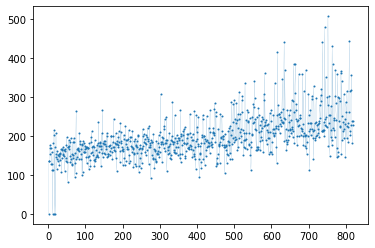

In [29]:
# Score obtained during training
x = list(range(1, len(Score) + 1))
plt.plot(x, Score, marker='o', linestyle='-',linewidth=0.1, markersize=1)
plt.show()